In [200]:
from PIL import Image
import numpy as np
from skimage.util import view_as_windows
from scipy.stats import norm
import torch
import matplotlib.pyplot as plt

In [206]:
def calculate_local_mse(image1, image2, kernel_size):
    assert image1.shape == image2.shape, "Images must have the same dimensions"

    windows1 = view_as_windows(image1, (kernel_size, kernel_size, 3), step=kernel_size)
    windows2 = view_as_windows(image2, (kernel_size, kernel_size, 3), step=kernel_size)
        
    local_mse = np.mean((windows1 - windows2) ** 2, axis=(2))
    return local_mse


def calculate_local_psnr(image1, image2, kernel_size):
    local_mse = calculate_local_mse(image1, image2, kernel_size)
    max_pixel_value = 255.0
    local_mse = np.clip(local_mse, a_min=1e-10, a_max=None)
    local_psnr = 10 * np.log10((max_pixel_value ** 2) / local_mse)
    
    return local_psnr

def normalize_psnr(psnr_values):
    psnr_values = np.clip(psnr_values, 0, 50)
    normalized_psnr = 255 * (psnr_values / 50)
    return normalized_psnr.astype(np.uint8)

def get_psnr_threshold(image, percentage):
    flat_psnr_values = image.flatten()
    sorted_psnr_values = np.sort(flat_psnr_values)
    n = len(sorted_psnr_values)
    index = int(percentage * n)
    threshold = sorted_psnr_values[index]
    
    return threshold

def get_mask(gt_array, render_array, kernel_size, percentage):
    my_psnr = calculate_local_psnr(gt_array, render_array, kernel_size)
    my_psnr= np.mean(my_psnr, axis=(2,3,4))

    normalized_psnr = normalize_psnr(my_psnr)
    psnr_image = np.repeat(np.repeat(normalized_psnr, kernel_size, axis=0), kernel_size, axis=1)
    
    q = get_psnr_threshold(psnr_image, percentage)
    psnr_image_modified = np.where(psnr_image <= q, 255, 0)
    
    return psnr_image_modified

In [207]:
render_folder_path = 'truck_render.png'
gt_folder_path = 'truck_gt.png'

gt_image = Image.open(gt_folder_path)
render_image = Image.open(render_folder_path)

gt_array = np.array(gt_image)
render_array = np.array(render_image)

In [208]:
kernel_size = 25
percentage = 0.25

In [209]:
psnr_image_modified = get_mask(gt_array, render_array, kernel_size, percentage)

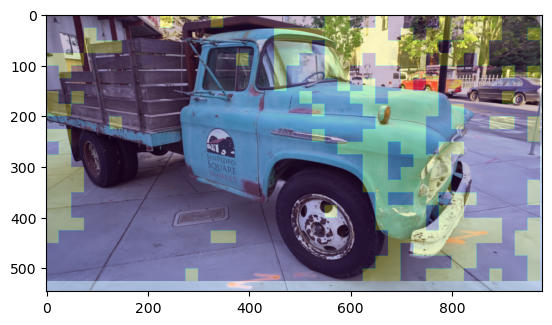

In [210]:
fig, ax = plt.subplots()
ax.imshow(psnr_image_modified)
ax.imshow(render_image, alpha=0.75)

plt.show()
